In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from plotnine import *


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, r2_score

%matplotlib inline


#read student performance file (sp)
sp = pd.read_csv('Cleaned_Students_Performance.csv')
sp.head()
sp.dropna(inplace=True)


In [ ]:
#Question 1: Linear Regression for Total scores by race and ethnicity

encoded = pd.get_dummies(sp, columns=['race_ethnicity'], drop_first=True)

#train/test split
X1 = encoded.filter(like='race_ethnicity')
y1 = sp['total_score']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

lr1= LinearRegression()
lr1.fit(X1_train, y1_train)

#eval
y1_pred = lr1.predict(X1_test)
r2_lr1 = r2_score(y1_test, y1_pred)
print(f'R2 Score: {r2_lr1}')

coefficients = pd.DataFrame({'Race/Ethnicity': X1.columns, 'Coefficient': lr1.coef_})
print(coefficients)





R2 Score: 0.01457894810763205
           Race/Ethnicity  Coefficient
0  race_ethnicity_group B     2.081557
1  race_ethnicity_group C     8.329320
2  race_ethnicity_group D    14.002511
3  race_ethnicity_group E    25.967516


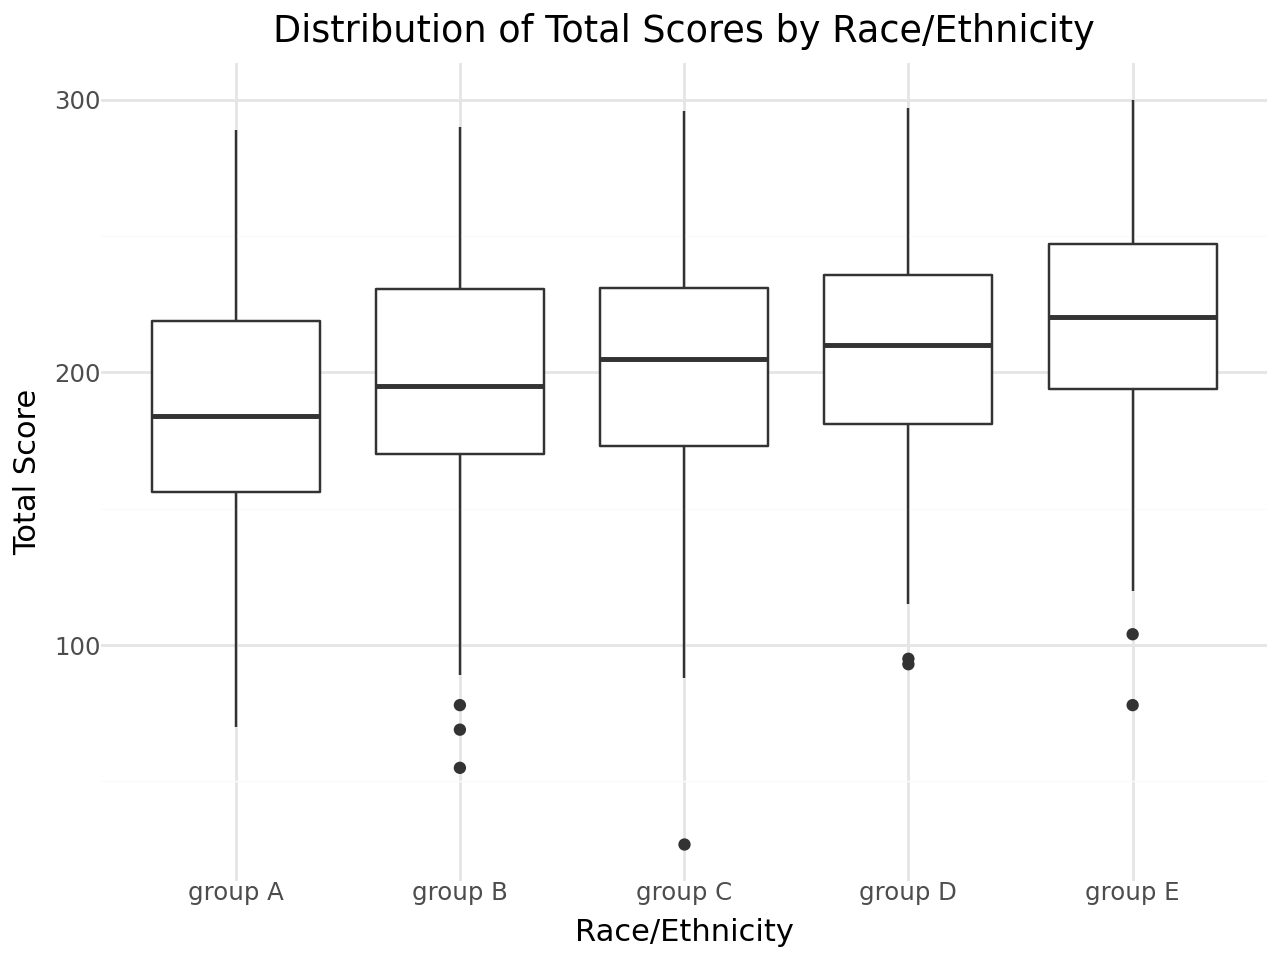

In [ ]:
#box plot for q1
(ggplot(sp, aes(x='race_ethnicity', y='total_score')) +
               geom_boxplot() +
               labs(title='Distribution of Total Scores by Race/Ethnicity',
                    x='Race/Ethnicity', y='Total Score') +
               theme_minimal())

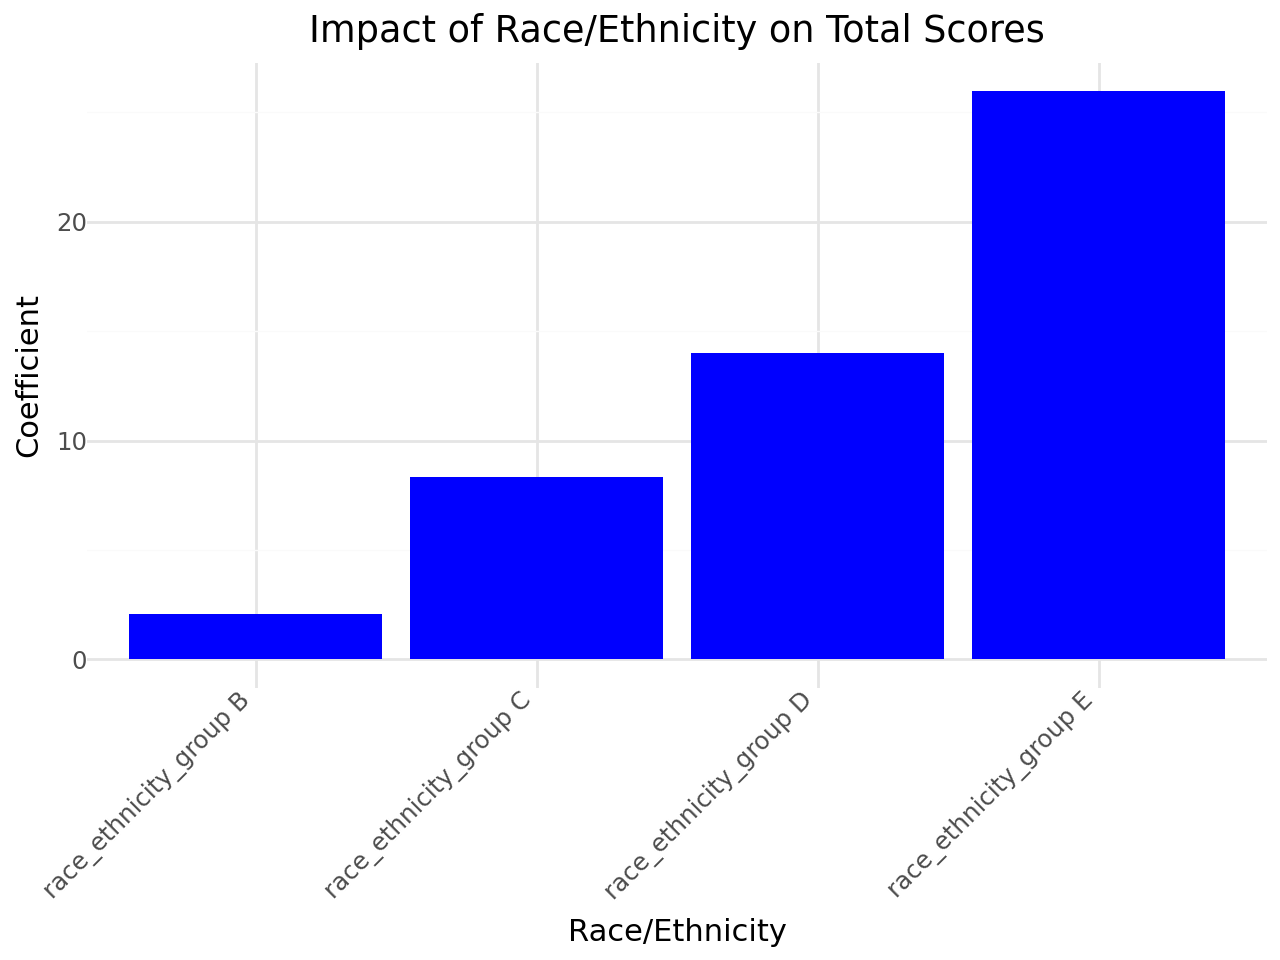

In [ ]:
#bar plot for Q1
(ggplot(coefficients, aes(x='Race/Ethnicity', y='Coefficient')) +
 geom_bar(stat='identity', fill='blue') +
 labs(title='Impact of Race/Ethnicity on Total Scores',
      x='Race/Ethnicity', y='Coefficient') +
 theme_minimal() +
 theme(axis_text_x=element_text(rotation=45, hjust=1)))




In [ ]:
# Question 2: test prep impact using KMeans

feats = ['math_score', 'reading_score', 'writing_score','gender', 'test_preparation_course']
X2 = sp[feats]

#standardizing feats
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2[['math_score', 'reading_score', 'writing_score']])

# Append categorical variables without scaling
X2_scaled = np.hstack((X2_scaled, X2[['gender', 'test_preparation_course']]))

#choose optimal k using silhouttte score
sil_scores = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X2_scaled)
    sil_scores.append(silhouette_score(X2_scaled,labels))
optimal_K = np.argmax(sil_scores) + 2
print(f'Optimal K: {optimal_K}')

#Fit with new k
kmeans = KMeans(n_clusters=optimal_K, random_state=42)
clusters = kmeans.fit_predict(X2_scaled)
sp['cluster'] = clusters

Optimal K: 2


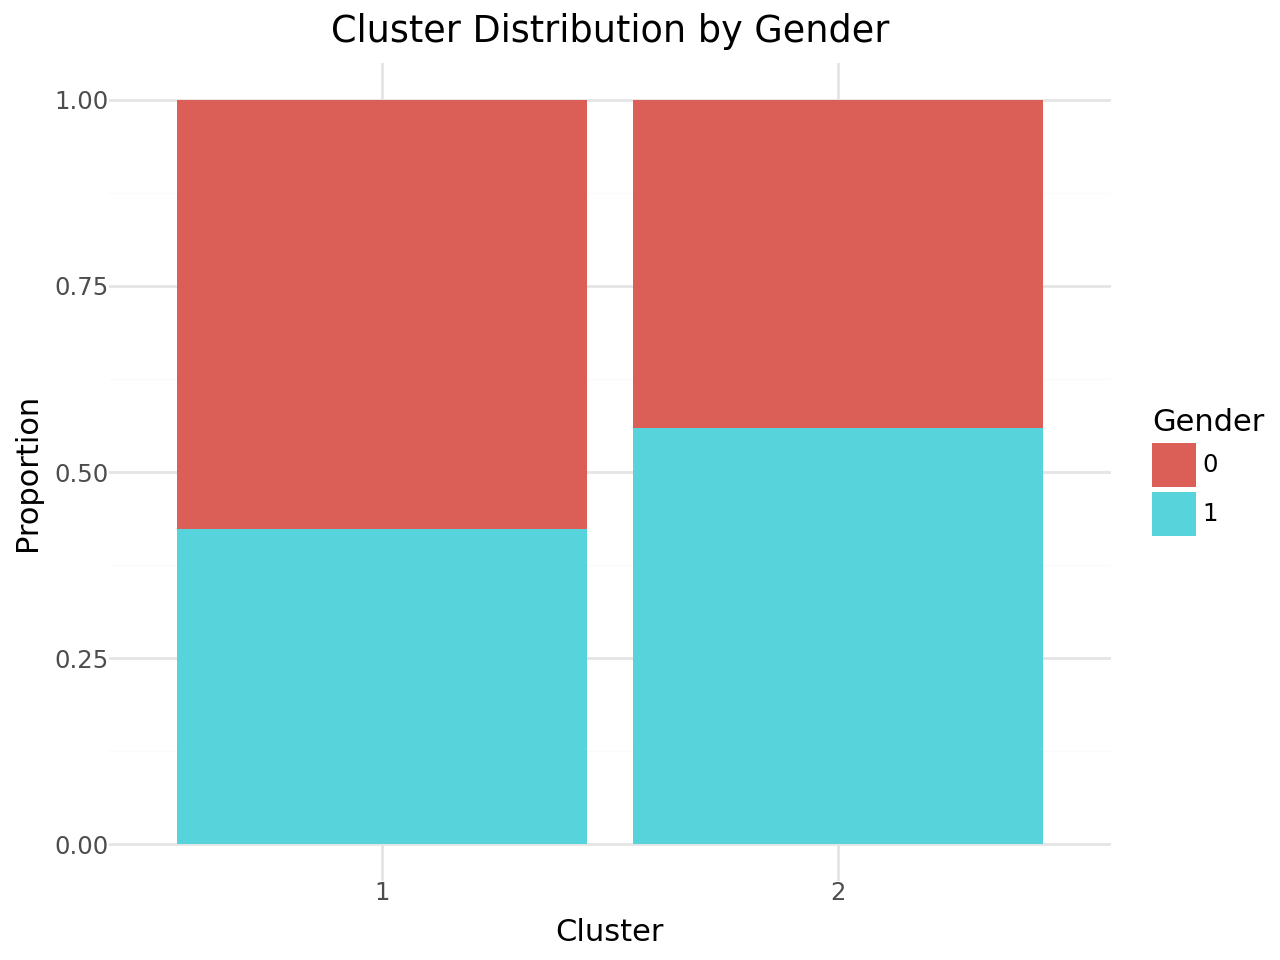

In [ ]:
# Bar chart: Cluster distribution by gender
(ggplot(sp, aes(x='factor(cluster + 1)', fill='factor(gender)')) +
 geom_bar(position='fill') +
 labs(title='Cluster Distribution by Gender',
      x='Cluster', y='Proportion', fill='Gender') +
 theme_minimal())

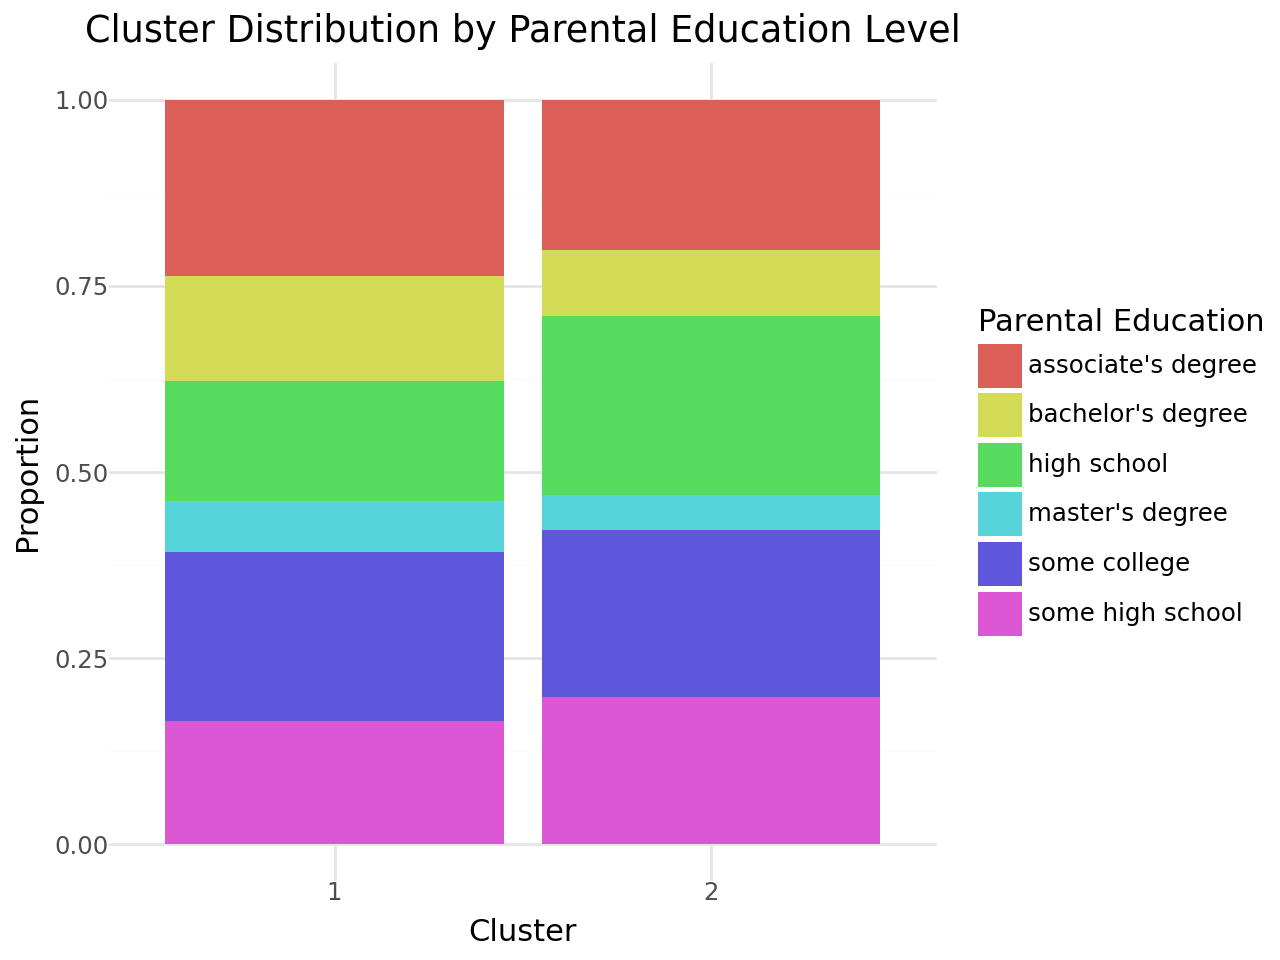

In [ ]:
# Bar chart: Cluster distribution by parental education
(ggplot(sp, aes(x='factor(cluster + 1)', fill='factor(parental_level_of_education)')) +
 geom_bar(position='fill') +
 labs(title='Cluster Distribution by Parental Education Level',
      x='Cluster', y='Proportion', fill='Parental Education') +
 theme_minimal())

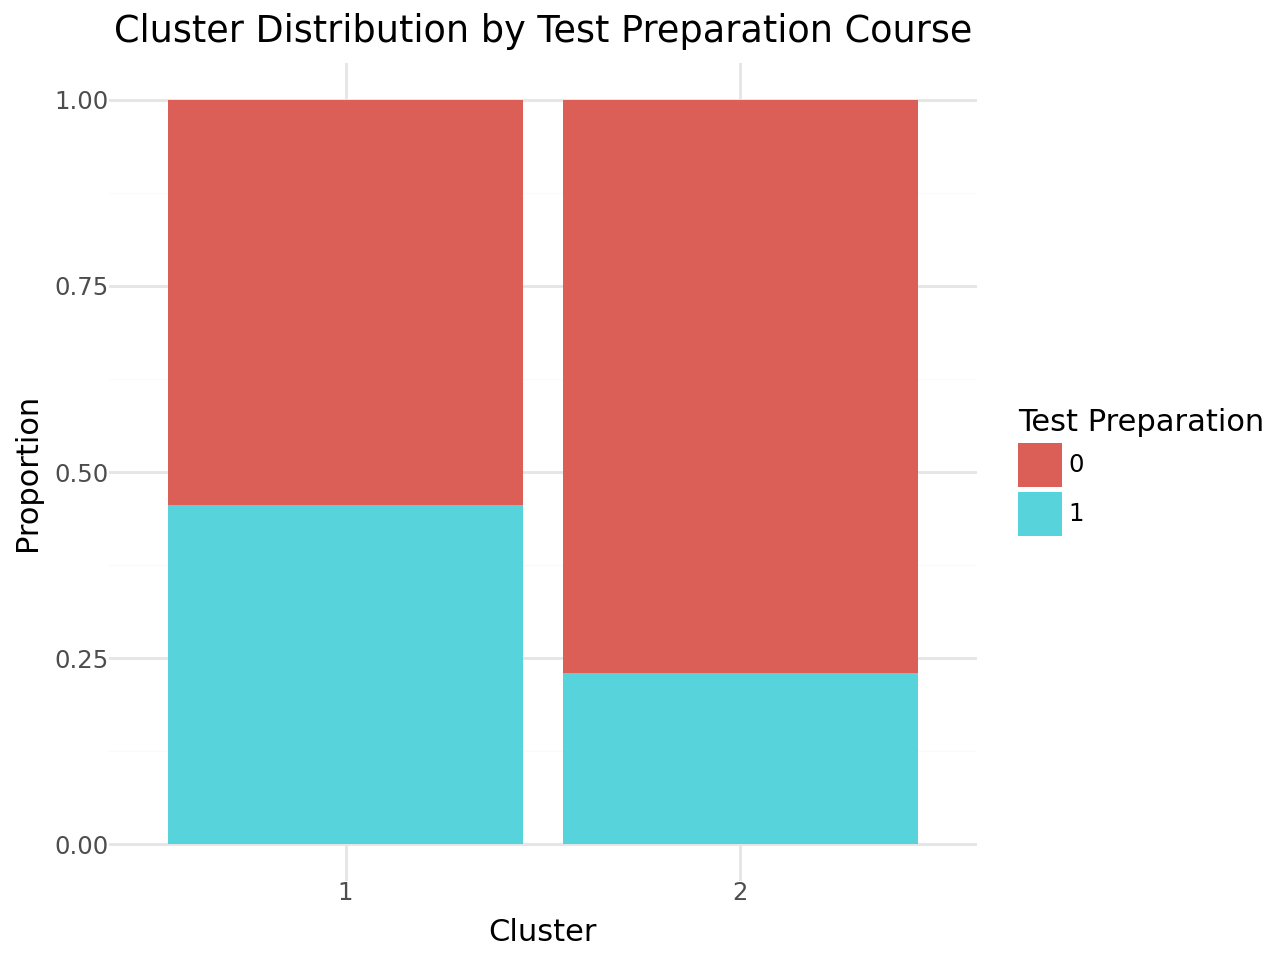

In [ ]:

#Bar plot of cluster distributions by test prep course
(ggplot(sp, aes(x='factor(cluster + 1)', fill='factor(test_preparation_course)')) +
    geom_bar(position='fill') +
    labs(title='Cluster Distribution by Test Preparation Course',
         x='Cluster', y='Proportion', fill='Test Preparation') +
    theme_minimal())



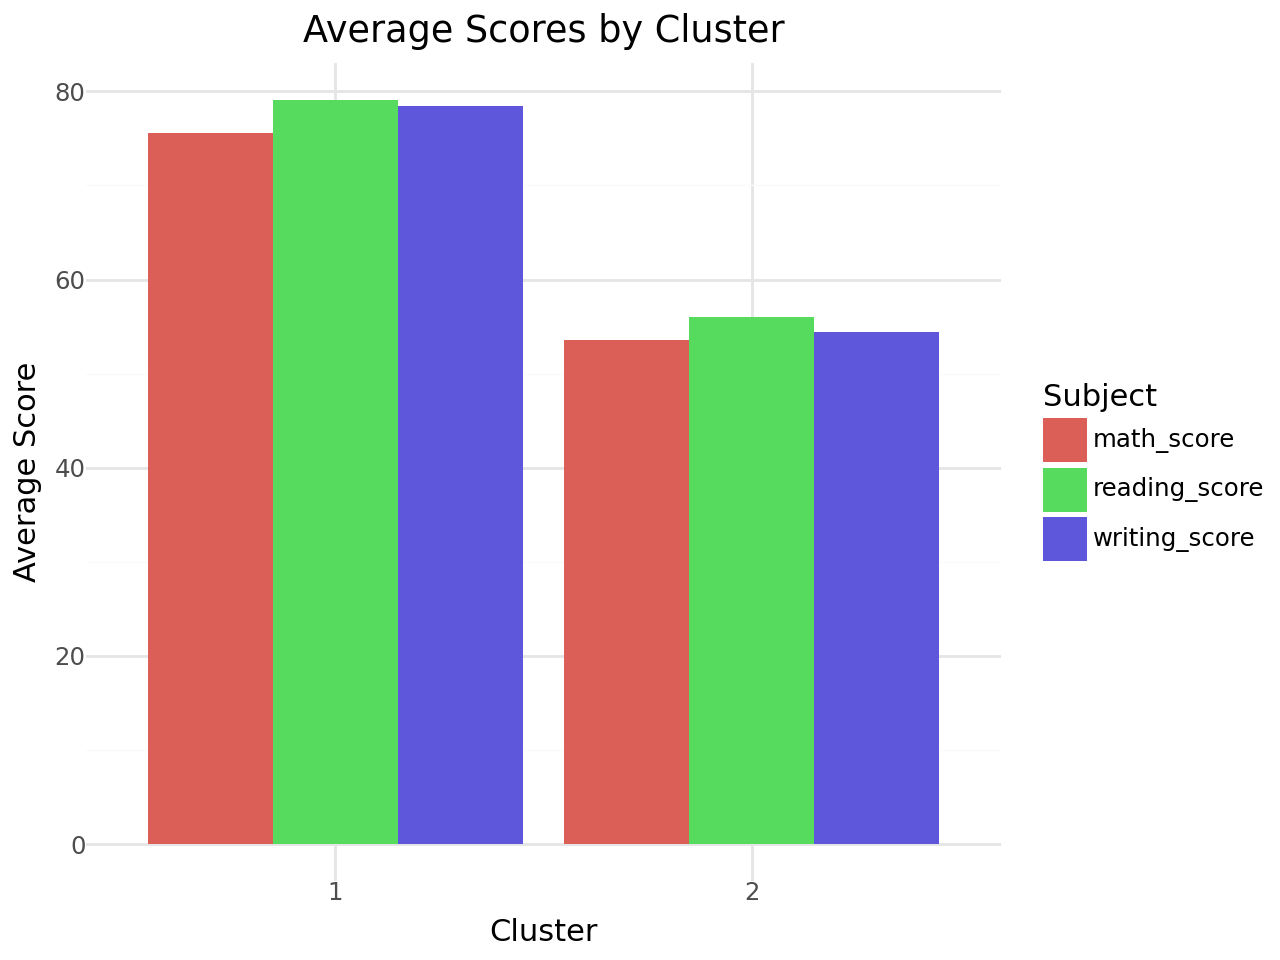

In [ ]:
# Question 2: Scores of each cluster
cluster_means = sp.groupby('cluster')[['math_score', 'reading_score', 'writing_score']].mean().reset_index()
cluster_means = cluster_means.melt(id_vars='cluster', var_name='Subject', value_name='Average Score')

(ggplot(cluster_means, aes(x='factor(cluster + 1)', y='Average Score', fill='Subject'))
  + geom_bar(stat='identity', position='dodge')
  + labs(title='Average Scores by Cluster', x='Cluster', y='Average Score', fill='Subject')
  + theme_minimal())

In [ ]:
# Question 3: PCA by Parent education and student performance consistency
X3 = sp[['math_score', 'reading_score', 'writing_score']]
pca = PCA(n_components=2)
X3_pca = pca.fit_transform(X3)
sp['PC1'], sp['PC2'] = X3_pca[:, 0], X3_pca[:, 1]

# Compute mean scores by parental education level
mean_scores = sp.groupby('parental_level_of_education')[['math_score', 'reading_score', 'writing_score']].mean().reset_index()



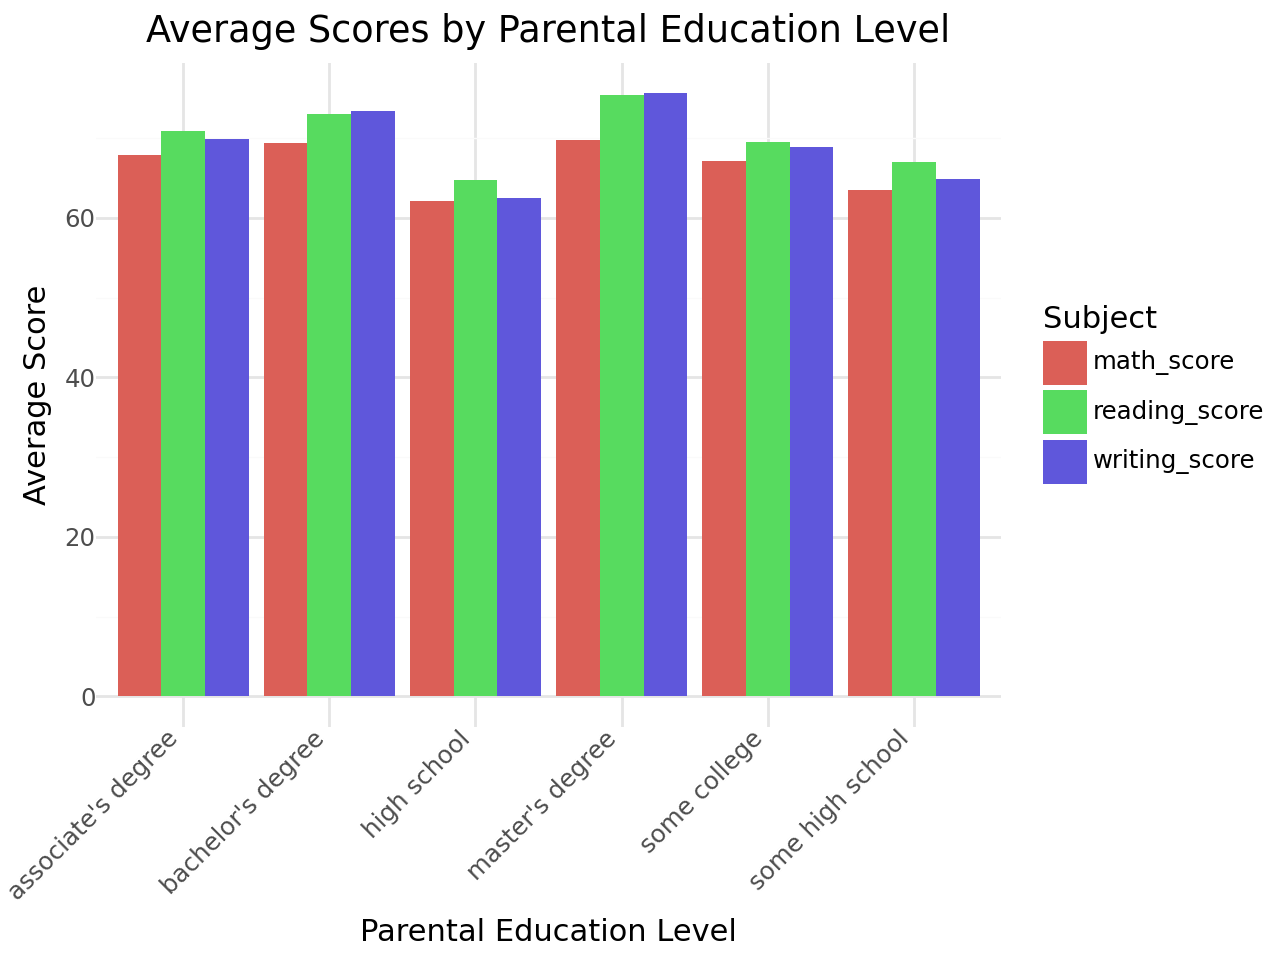

In [ ]:
# Question 3 Graph 1: Grouped bar chart of average scores
(ggplot(mean_scores.melt(id_vars='parental_level_of_education',
                         var_name='Subject',
                         value_name='Average Score')) +
 geom_bar(aes(x='parental_level_of_education', y='Average Score', fill='Subject'),
          stat='identity', position='dodge') +
 labs(title='Average Scores by Parental Education Level',
      x='Parental Education Level', y='Average Score', fill='Subject') +
 theme_minimal()+
 theme(axis_text_x=element_text(rotation=45, hjust=1)))


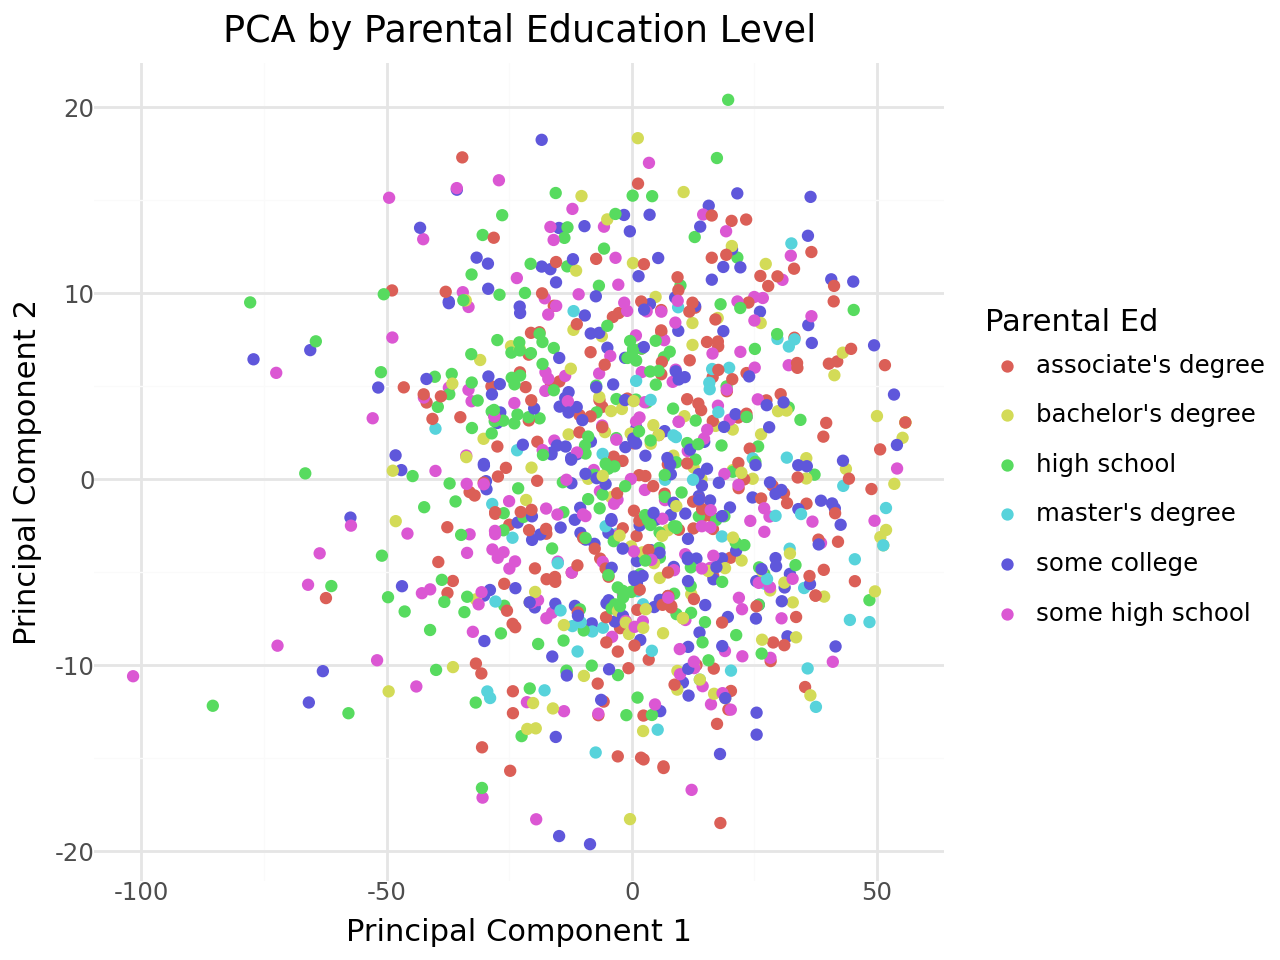

In [ ]:
# Question 3 Graph 2: PCA scatterplot
#The PCA transformation combines the three subject scoresinto two components PC1 and PC2.
(ggplot(sp, aes(x='PC1', y='PC2', color='parental_level_of_education')) +
                   geom_point() +
                   labs(title='PCA by Parental Education Level',
                        x='Principal Component 1', y='Principal Component 2', color='Parental Ed') +
                   theme_minimal())


In [ ]:
# Question 4: Average score comparison
X4 = pd.get_dummies(sp[['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']], drop_first=True)
y4 = sp['average_score']

# Train/test split
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)


lr4 = LinearRegression()
lr4.fit(X4_train, y4_train)
r2_full = r2_score(y4_test, lr4.predict(X4_test))

# Models with one predictor removed
r2_scores = []
for col in X4.columns:
    X_temp = X4.drop(columns=[col])
    X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_temp, y4, test_size=0.2, random_state=42)
    lr_temp = LinearRegression()
    lr_temp.fit(X_temp_train, y_temp_train)
    r2_scores.append((col, r2_score(y_temp_test, lr_temp.predict(X_temp_test))))

#r^2 comparison
r2_df = pd.DataFrame(r2_scores, columns=['Predictor Removed', 'R² Score'])
print(r2_df)




                                Predictor Removed  R² Score
0                                          gender  0.159333
1                                           lunch  0.112879
2                         test_preparation_course  0.115144
3                          race_ethnicity_group B  0.162794
4                          race_ethnicity_group C  0.157702
5                          race_ethnicity_group D  0.142326
6                          race_ethnicity_group E  0.137622
7   parental_level_of_education_bachelor's degree  0.170271
8         parental_level_of_education_high school  0.139880
9     parental_level_of_education_master's degree  0.152529
10       parental_level_of_education_some college  0.161459
11   parental_level_of_education_some high school  0.137466


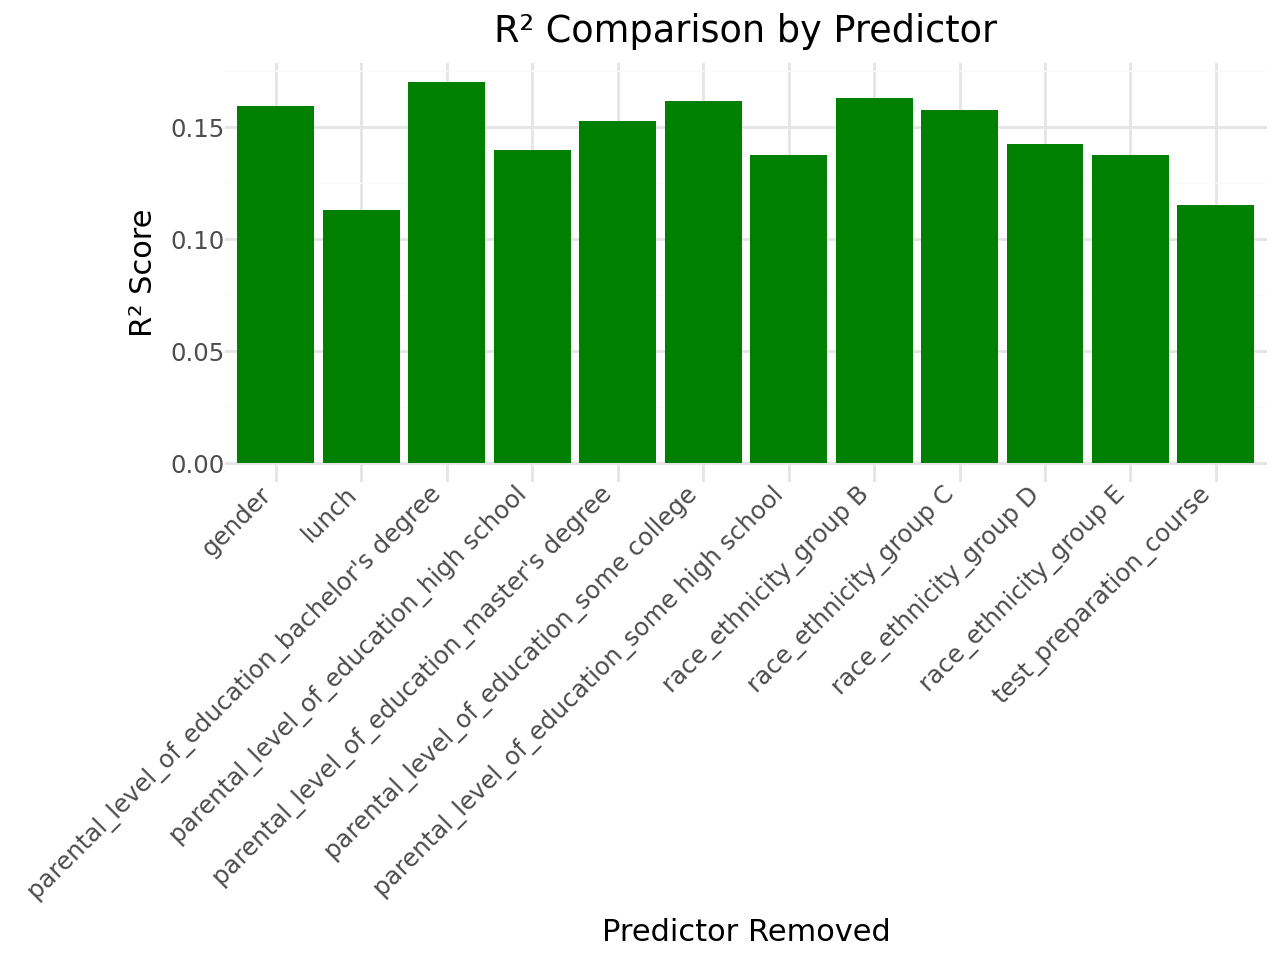

In [ ]:
#bar plot of  r^2scores
(ggplot(r2_df, aes(x='Predictor Removed', y='R² Score')) +
               geom_bar(stat='identity', fill='green') +
               labs(title='R² Comparison by Predictor',
                    x='Predictor Removed', y='R² Score') +
               theme_minimal() +
 theme(axis_text_x=element_text(rotation=45, hjust=1)))


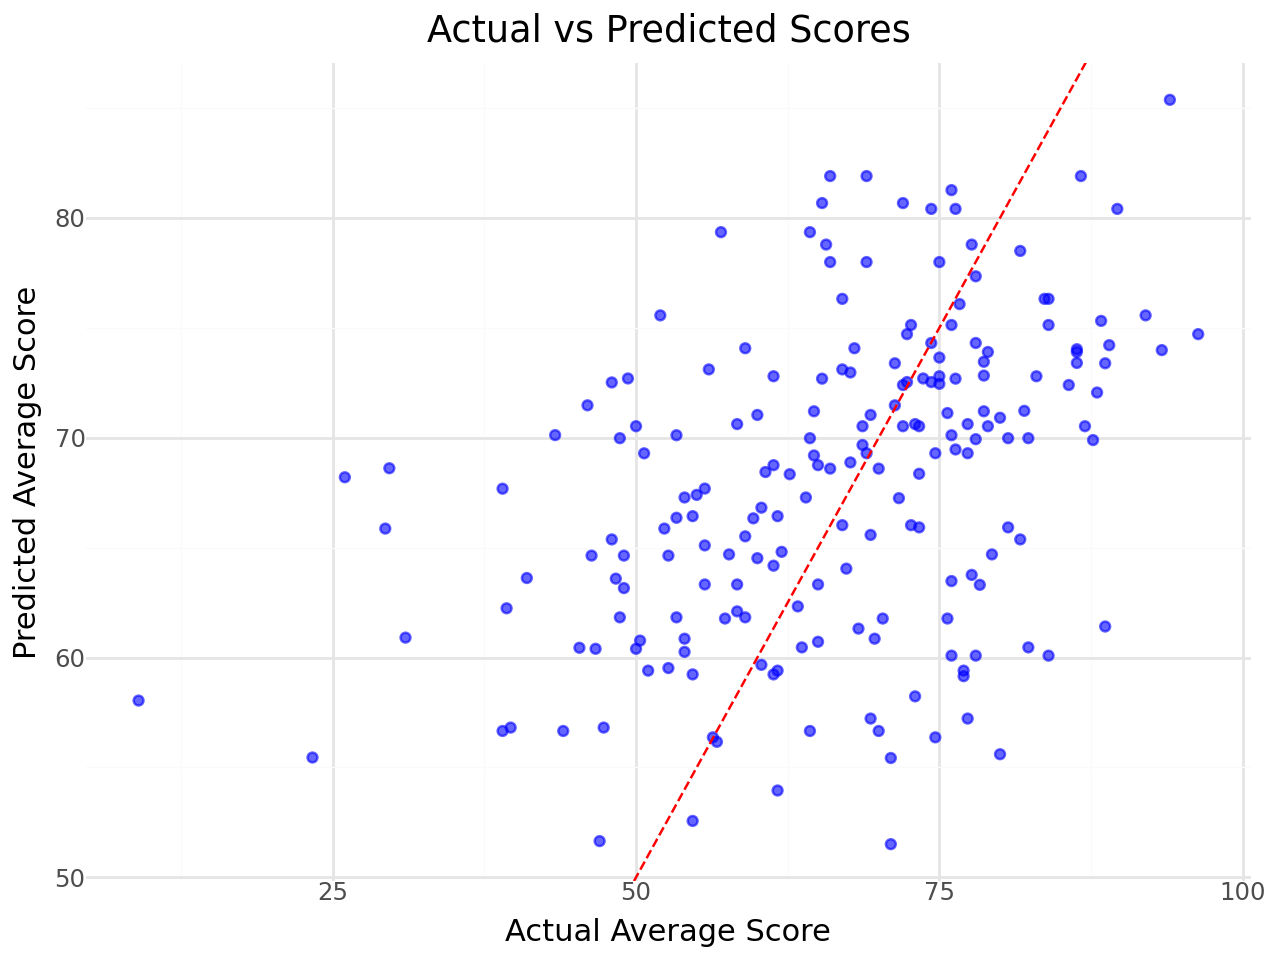

In [ ]:
# predictions vs actual scores
y4_pred = lr4.predict(X4_test)
(ggplot(pd.DataFrame({'Actual': y4_test, 'Predicted': y4_pred}),
                         aes(x='Actual', y='Predicted')) +
                   geom_point(alpha=0.6, color='blue') +
                   geom_abline(intercept=0, slope=1, linetype='dashed', color='red') +
                   labs(title='Actual vs Predicted Scores',
                        x='Actual Average Score', y='Predicted Average Score') +
                   theme_minimal())
